In [14]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, zscore, spearmanr, binom

## Plotting parameters

In [15]:
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

FIGWIDTH = 7.00697
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
N_TRIALS = 20

# green for gpt-4v, gray for fuyu, purple for adapter, teal for otter, red for humans
model_colors = [
    "#50b990",
    "#8c92ac",
    "#624fe8",
    "#008080",
    "#9b443e",
]

cmap = [
    "#9b443e",
    "#53665c",
    "#ccb3a0",
    "#f4b368",
    "#a08158",
    "#c87858",
    "#94b1d2",
    "#c5d9d8",
    "#e6b951",
    "#666666",
]
sns.set_palette(cmap)


plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


latex_context = {
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
}


# retina figures
mpl.rcParams["figure.dpi"] = 301
mpl.rcParams["savefig.dpi"] = 311

## Load data

In [16]:
# Load data from our own collected .csv file
data = pd.read_csv("data/NUC_RESULTS.csv").loc[:, :"OTTER"]

# Define subjects
subjects = ["Human", "GPT4V1Q", "FUYU", "ADAPTER", "OTTER"]

# Print first five rows
data.head()

,ExpId,Type,Variable,Lower,Upper,Human,TerrainNo,JointInference,RateInference,Heuristic,Z_JointInference,Z_RateInference,Id,GPT4V1Q,FUYU,ADAPTER,OTTER
0,0,Cost,Outside,-0.520237,0.035730,-0.228961,1.0,6.084458,6.609310,-0.384085,0.638085,0.791911,a,5.0,0,5.0,7
1,0,Reward,TopTreat,-0.937563,-0.485594,-0.702174,1.0,5.303722,0.627995,-0.734847,-0.873092,-1.125956,a,0.0,3,8.0,8
2,1,Cost,Outside,-0.584346,-0.081584,-0.329477,1.0,3.761888,5.002669,-1.032952,-0.654537,-0.312576,a,7.0,0,3.0,7
3,1,Reward,TopTreat,1.175349,1.466409,1.312890,1.0,19.751687,15.241414,1.306395,1.478922,0.759633,a,7.0,3,8.0,8
4,2,Cost,Outside,-0.395186,0.067293,-0.170184,1.0,5.383781,4.983377,-0.384085,0.248124,-0.325838,a,5.0,0,NaN,7


In [17]:
# Load data from our own collected .csv file
descriptives = pd.read_csv("data/NUC_DESCRIPTIVES.csv")
descriptives.head()

# Get percentage of correct background color over all three experiments
color_correct = np.zeros(len(subjects[1:]))
color_correct_errs = np.zeros(len(subjects[1:]))
for ind, subject in enumerate(subjects[1:]):
    color_correct[ind] = sum(descriptives.loc[descriptives["Question"] == 1, subject].isin(["purple", "pink"])) / len(descriptives.loc[descriptives["Question"] == 1])
    color_correct_errs[ind] = binom.std(len(descriptives.loc[descriptives["Question"] == 1]), color_correct[ind])

In [18]:
# Make new Z-transform columns
for subject in subjects[1:]:
    data[f"{subject}-Z"] = np.zeros(data.shape[0])
    data[f"{subject}-Z"] = np.nan

    # Add z-scored columns for each experiment
    for exp in ["a", "b", "c"]:

        # Z-Score for both judgement types separately
        data.loc[(data["Id"] == exp) & (data["Type"] == "Cost"), f"{subject}-Z"] = zscore(data.loc[(data["Id"] == exp) & (data["Type"] == "Cost"), f"{subject}"], nan_policy="omit")
        data.loc[(data["Id"] == exp) & (data["Type"] == "Reward"), f"{subject}-Z"] = zscore(data.loc[(data["Id"] == exp) & (data["Type"] == "Reward"), f"{subject}"], nan_policy="omit")

# Print first five rows
data.head()

,ExpId,Type,Variable,Lower,Upper,Human,TerrainNo,JointInference,RateInference,Heuristic,...,Z_RateInference,Id,GPT4V1Q,FUYU,ADAPTER,OTTER,GPT4V1Q-Z,FUYU-Z,ADAPTER-Z,OTTER-Z
0,0,Cost,Outside,-0.520237,0.035730,-0.228961,1.0,6.084458,6.609310,-0.384085,...,0.791911,a,5.0,0,5.0,7,-0.469029,NaN,0.861727,NaN
1,0,Reward,TopTreat,-0.937563,-0.485594,-0.702174,1.0,5.303722,0.627995,-0.734847,...,-1.125956,a,0.0,3,8.0,8,-0.450420,-0.204124,NaN,1.128152
2,1,Cost,Outside,-0.584346,-0.081584,-0.329477,1.0,3.761888,5.002669,-1.032952,...,-0.312576,a,7.0,0,3.0,7,0.617143,NaN,-0.976624,NaN
3,1,Reward,TopTreat,1.175349,1.466409,1.312890,1.0,19.751687,15.241414,1.306395,...,0.759633,a,7.0,3,8.0,8,1.682451,-0.204124,NaN,1.128152
4,2,Cost,Outside,-0.395186,0.067293,-0.170184,1.0,5.383781,4.983377,-0.384085,...,-0.325838,a,5.0,0,NaN,7,-0.469029,NaN,NaN,NaN


## Analyze correlation with human data

In [19]:
# Same but only for cost trials
cost = data[data["Type"] == "Cost"]
reward = data[data["Type"] == "Reward"]

# Pre-allocate result arrays
cocorr_all = np.zeros(len(subjects[1:]))
recorr_all = np.zeros(len(subjects[1:]))
cocorr_cis = np.zeros((2, len(subjects[1:])))
recorr_cis = np.zeros((2, len(subjects[1:])))
heucocorr_all = np.zeros(len(subjects[1:]))
heurecorr_all = np.zeros(len(subjects[1:]))

for ind, subject in enumerate(subjects[1:]):  

    # Get correlation for subject vs human cost questions
    na = np.logical_or(np.isnan(cost[subject]), np.isnan(cost["Human"]))
    corr = pearsonr(cost[subject][~na], cost["Human"][~na])
    print(f"All experiments: {subject} correlation with humans for cost questions is {corr.statistic:.4f}, with p-value {corr.pvalue:.4f}")
    cocorr_all[ind] = corr.statistic
    cocorr_cis[0, ind] = corr.statistic - corr.confidence_interval()[0]
    cocorr_cis[1, ind] = corr.confidence_interval()[1] - corr.statistic

    # Get correlation for subject vs human reward questions
    na = np.logical_or(np.isnan(reward[subject]), np.isnan(reward["Human"]))
    corr = pearsonr(reward[subject][~na], reward["Human"][~na])
    print(f"All experiments: {subject} correlation with humans for reward questions is {corr.statistic:.4f}, with p-value {corr.pvalue:.4f}")
    recorr_all[ind] = corr.statistic
    recorr_cis[0, ind] = corr.statistic - corr.confidence_interval()[0]
    recorr_cis[1, ind] = corr.confidence_interval()[1] - corr.statistic

    # # Get correlation for subject vs heuristic cost questions
    na = np.logical_or(np.isnan(cost[subject]), np.isnan(cost["Heuristic"]))
    corr = pearsonr(cost[subject][~na], cost["Heuristic"][~na])
    print(f"All experiments: {subject} correlation with heuristic for cost questions is {corr.statistic:.4f}, with p-value {corr.pvalue:.4f}")
    heucocorr_all[ind] = corr.statistic

    # Get correlation for subject vs human reward questions
    na = np.logical_or(np.isnan(reward[subject]), np.isnan(reward["Heuristic"]))
    corr = pearsonr(reward[subject][~na], reward["Heuristic"][~na])
    print(f"All experiments: {subject} correlation with heuristic for reward questions is {corr.statistic:.4f}, with p-value {corr.pvalue:.4f}")
    heurecorr_all[ind] = corr.statistic

All experiments: GPT4V1Q correlation with humans for cost questions is -0.0185, with p-value 0.8801
All experiments: GPT4V1Q correlation with humans for reward questions is 0.1728, with p-value 0.1588
All experiments: GPT4V1Q correlation with heuristic for cost questions is -0.0806, with p-value 0.5106
All experiments: GPT4V1Q correlation with heuristic for reward questions is 0.1299, with p-value 0.2912
All experiments: FUYU correlation with humans for cost questions is nan, with p-value nan
All experiments: FUYU correlation with humans for reward questions is 0.1125, with p-value 0.3539
All experiments: FUYU correlation with heuristic for cost questions is nan, with p-value nan
All experiments: FUYU correlation with heuristic for reward questions is 0.1066, with p-value 0.3797
All experiments: ADAPTER correlation with humans for cost questions is 0.0104, with p-value 0.9323
All experiments: ADAPTER correlation with humans for reward questions is nan, with p-value nan
All experiments:

/Users/luca/Library/Python/3.9/lib/python/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [20]:
# Pre-allocate result arrays
cost_corrs = np.zeros((3, len(subjects[1:])))
reward_corrs = np.zeros((3, len(subjects[1:])))
cost_corrs[:,:] = np.nan
cost_corrs[:,:] = np.nan
 
# Loop through experiments and subject
for ind1, exp in enumerate(["a", "b", "c"]):
    for ind2, subject in enumerate(subjects[1:]):  

        cocorr = spearmanr(cost[cost["Id"] == exp][subject].values, cost[cost["Id"] == exp]["Human"].values, nan_policy="omit")
        if not np.isnan(cocorr.statistic):
            cost_corrs[ind1, ind2] = cocorr.statistic

        recorr = spearmanr(reward[reward["Id"] == exp][subject].values, reward[reward["Id"] == exp]["Human"].values, nan_policy="omit")
        if not np.isnan(recorr.statistic):
            reward_corrs[ind1, ind2] = recorr.statistic

        # Print results
        print(f"Experiment 1{exp}: {subject} correlation with human average for cost questions is {cocorr.statistic:.4f} with p value {cocorr.pvalue:.4f}.")
        print(f"Experiment 1{exp}: {subject} correlation with human average for reward questions is {recorr.statistic:.4f} with p value {recorr.pvalue:.4f}.")

Experiment 1a: GPT4V1Q correlation with human average for cost questions is -0.2950 with p value 0.1826.
Experiment 1a: GPT4V1Q correlation with human average for reward questions is 0.4558 with p value 0.0288.
Experiment 1a: FUYU correlation with human average for cost questions is nan with p value nan.
Experiment 1a: FUYU correlation with human average for reward questions is -0.1415 with p value 0.4998.
Experiment 1a: ADAPTER correlation with human average for cost questions is -0.2561 with p value 0.3384.
Experiment 1a: ADAPTER correlation with human average for reward questions is nan with p value nan.
Experiment 1a: OTTER correlation with human average for cost questions is nan with p value nan.
Experiment 1a: OTTER correlation with human average for reward questions is -0.1117 with p value 0.5949.
Experiment 1b: GPT4V1Q correlation with human average for cost questions is 0.0946 with p value 0.6603.
Experiment 1b: GPT4V1Q correlation with human average for reward questions is 0.

/Users/luca/Library/Python/3.9/lib/python/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [21]:
# Get percentage of correct background color over all three experiments
color_correct = np.zeros(len(subjects[1:]))
for ind, subject in enumerate(subjects[1:]):
    color_correct[ind] = sum(descriptives.loc[descriptives["Question"] == 1, subject].isin(["purple", "pink"])) / len(descriptives.loc[descriptives["Question"] == 1])

## Make main plot
I imagine a plot with 4 panels, single row with four columns,  for every study
- A: Barplots model comparison for background color task. Bars show percentage correct.
- B: Counting model comparison as in A
- C: Reasoning ground truth comparison as in A
- D: Match to humans,  probably via regression coefficient.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


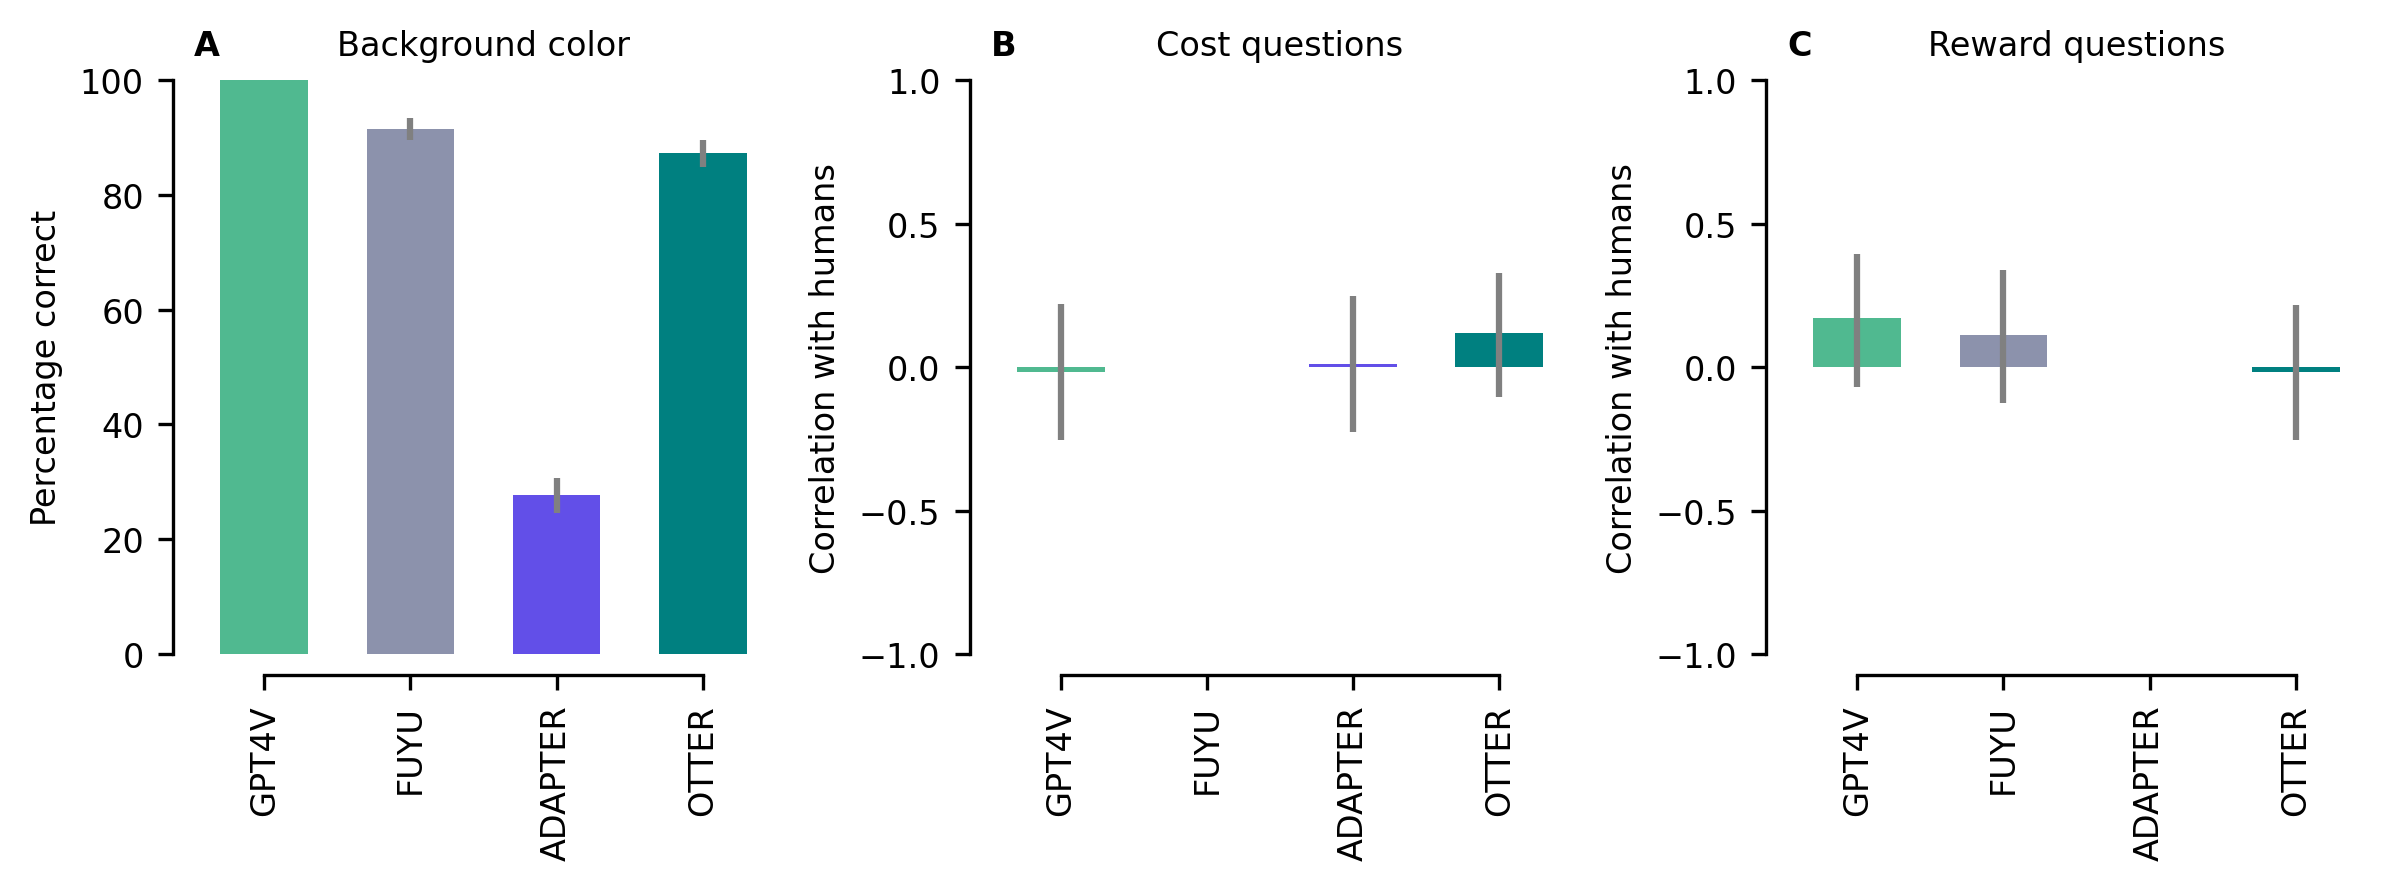

In [22]:
# Prepare plot
num_subjects = len(subjects)
fig, axs = plt.subplots(1, 3, figsize=(8,3), sharey=False, tight_layout=True)  

# Plot A
axs[0].bar(np.arange(num_subjects-1), color_correct*100, color=model_colors, width=0.6)
axs[0].errorbar(np.arange(num_subjects-1), 
                color_correct*100, 
                yerr=color_correct_errs, ls="none", ecolor="gray")
axs[0].set_title("Background color")
axs[0].set_title("A", fontweight='bold', loc='left')
axs[0].set_ylabel("Percentage correct")
axs[0].set_ylim(0, 100)
axs[0].set_xticks(np.arange(num_subjects-1))

# Plot B
axs[1].bar(np.arange(num_subjects-1), cocorr_all, color=model_colors[:-1], width=0.6)
axs[1].errorbar(np.arange(num_subjects-1), 
                cocorr_all, 
                yerr=cocorr_cis, ls="none", ecolor="gray")
axs[1].set_title("Cost questions")
axs[1].set_title("B", fontweight='bold', loc='left')
axs[1].set_ylabel("Correlation with humans")
axs[1].set_ylim(-1, 1)
axs[1].set_yticks(np.arange(-1, 1.1, 0.5))
axs[1].set_xticks(np.arange(num_subjects-1))
axs[1].legend(loc="upper center", frameon=False)

# Plot C
axs[2].bar(np.arange(num_subjects-1), recorr_all, color=model_colors[:-1], width=0.6)
axs[2].errorbar(np.arange(num_subjects-1), 
                recorr_all, 
                yerr=recorr_cis, ls="none", ecolor="gray")
axs[2].set_title("Reward questions")
axs[2].set_title("C", fontweight='bold', loc='left')
axs[2].set_ylabel("Correlation with humans")
axs[2].set_ylim(-1, 1)
axs[2].set_yticks(np.arange(-1, 1.1, 0.5))
axs[2].set_xticks(np.arange(num_subjects-1))

# Despine and set x tick labels afterwards
sns.despine(offset=5, trim=True)
axs[0].set_xticklabels(np.concatenate((["GPT4V"], subjects[2:])), rotation=90)
axs[1].set_xticklabels(np.concatenate((["GPT4V"], subjects[2:])), rotation=90)
axs[2].set_xticklabels(np.concatenate((["GPT4V"], subjects[2:])), rotation=90)
plt.savefig("figures/psych_main.pdf", dpi=300)

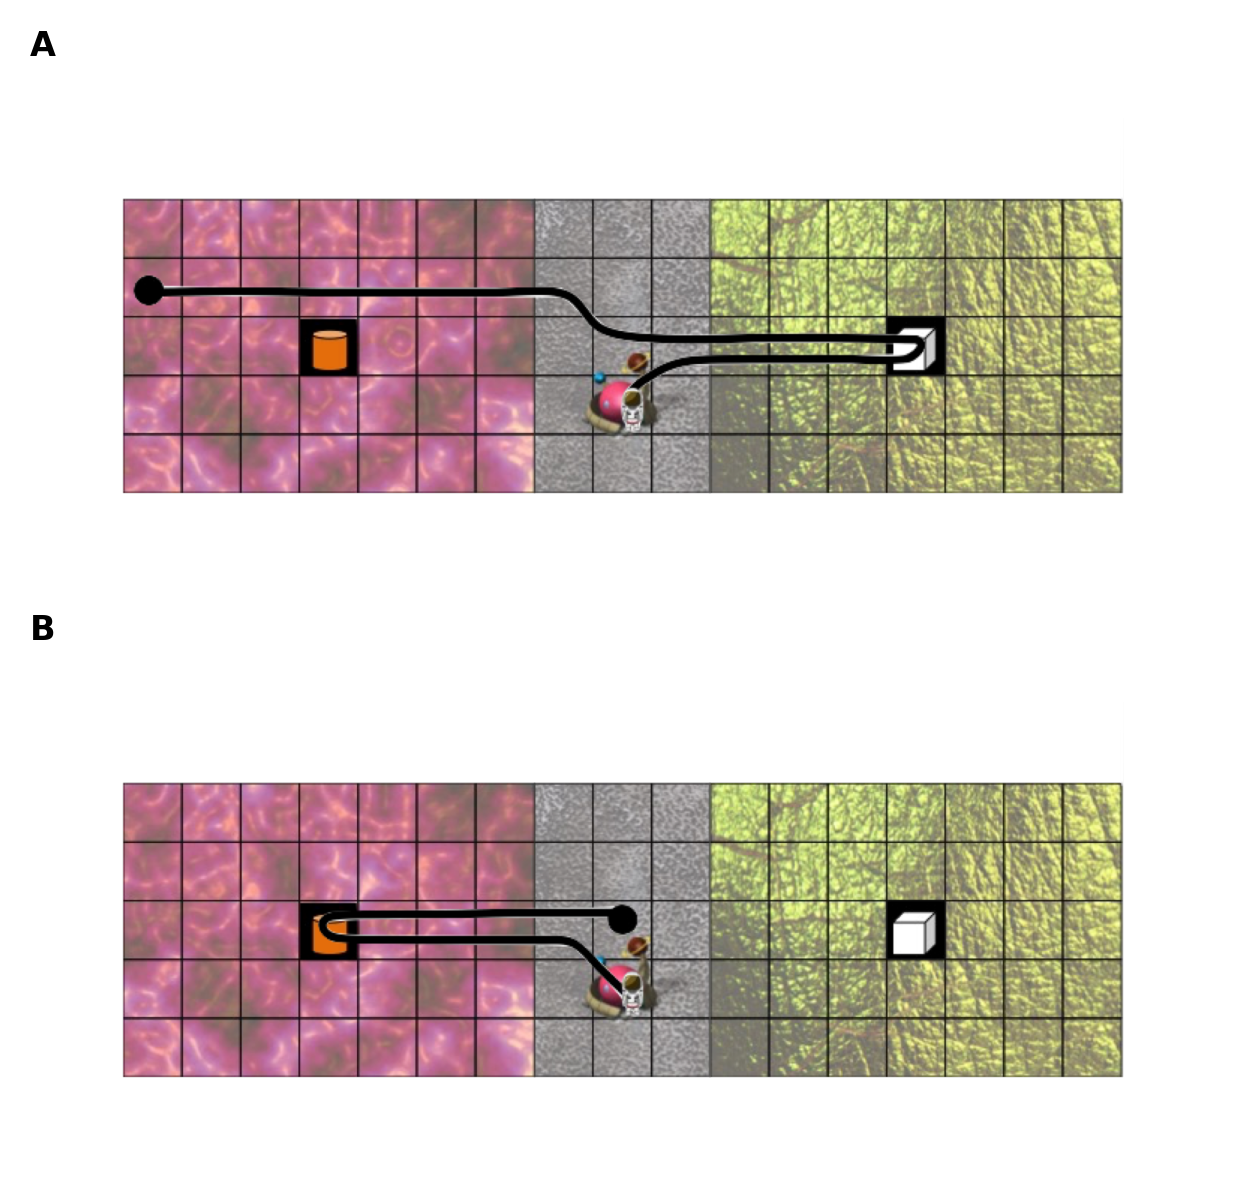

In [23]:
# Prepare plot
fig, axs = plt.subplots(2, 1, sharey=False, tight_layout=True, figsize=(6,4))  

# First column: easy for humans, hard for GPT4V (20, 11)
axs[0].imshow(plt.imread("eval/images/naive_util_calc_images/Exp1b/3.png"))
axs[0].set_title("A\n", fontweight='bold', loc='left', fontsize='medium')
axs[0].axis("off")

axs[1].imshow(plt.imread("eval/images/naive_util_calc_images/Exp1b/1.png"))
axs[1].set_title("B\n", fontweight='bold', loc='left', fontsize='medium')
axs[1].axis("off")

plt.savefig("figures/psych_examples1.pdf", dpi=300, bbox_inches='tight')

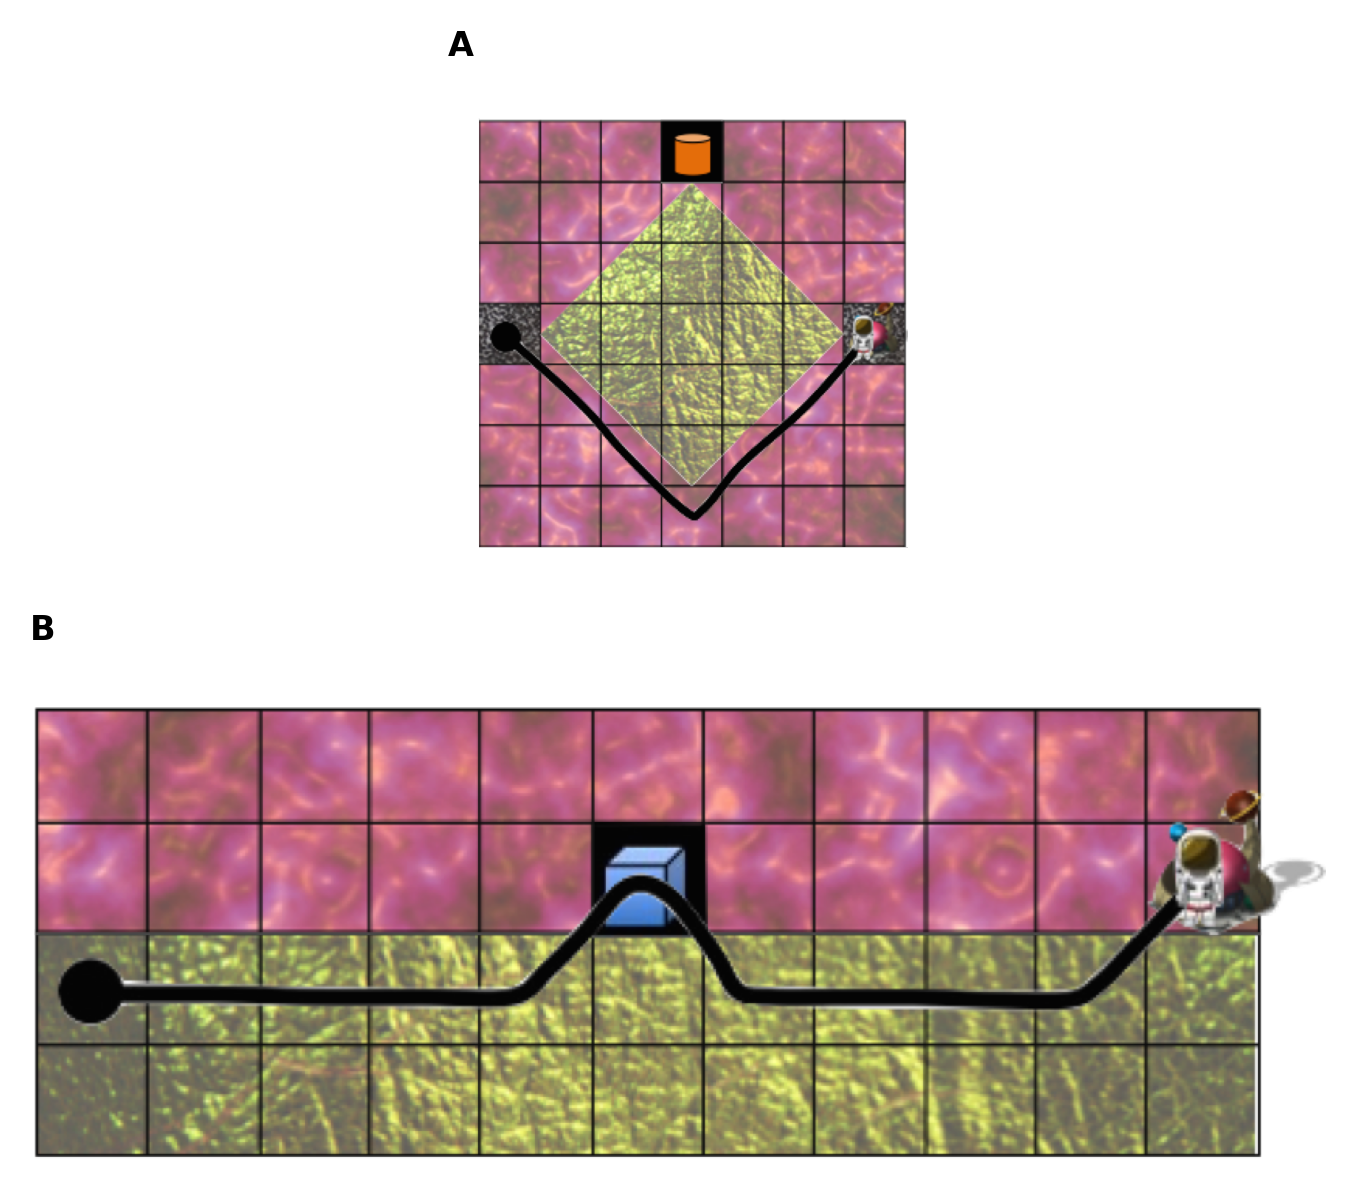

In [24]:
# Prepare plot
fig, axs = plt.subplots(2, 1, sharey=False, tight_layout=True, figsize=(6,4))  

axs[0].imshow(plt.imread("eval/images/naive_util_calc_images/Exp1a/10.png"))
axs[0].set_title("A\n", fontweight='bold', loc='left', fontsize='medium')
axs[0].axis("off")

axs[1].imshow(plt.imread("eval/images/naive_util_calc_images/Exp1c/7.png"))
axs[1].set_title("B\n", fontweight='bold', loc='left', fontsize='medium')
axs[1].axis("off")

plt.savefig("figures/psych_examples2.pdf", dpi=300, bbox_inches='tight')